In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer,AutoProcessor, BitsAndBytesConfig, get_scheduler,Gemma3ForConditionalGeneration
from bitsandbytes.optim import Adam8bit,PagedAdam32bit
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
from peft import prepare_model_for_kbit_training
import torch
from IPython.display import  clear_output
import time
import gc
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

DEFAULT_MODEL = "google/gemma-3-4b-it"

bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=False,
    )


model = Gemma3ForConditionalGeneration.from_pretrained(
    DEFAULT_MODEL,
    quantization_config=bnb_config,
    attn_implementation='eager',
    device_map=device,
    torch_dtype=torch.bfloat16
    
)

print(model.get_memory_footprint()/(1024*1024)) 

tokenizer = AutoTokenizer.from_pretrained(DEFAULT_MODEL)

def flush():
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

3023.7419147491455


# Load a Multi Lingual Dataset

In [2]:
from datasets import load_dataset

# Load the dataset
# dataset = load_dataset("OdiaGenAI/hardcode_odia_qa_105")
dataset = load_dataset('OdiaGenAI/odia_domain_context_train_v1')

In [3]:
dataset['train'][50]

{'instruction': '‡¨ì‡¨°‡¨º‡¨ø‡¨∂‡¨æ‡¨∞ ‡¨â‡¨¶‡≠ü‡¨ó‡¨ø‡¨∞‡¨ø ‡¨è‡¨¨‡¨Ç ‡¨ñ‡¨£‡≠ç‡¨°‡¨ó‡¨ø‡¨∞‡¨ø ‡¨ó‡≠Å‡¨Æ‡≠ç‡¨´‡¨æ‡¨∞ ‡¨á‡¨§‡¨ø‡¨π‡¨æ‡¨∏ ‡¨ï‚Äô‡¨£?',
 'input': '',
 'output': '‡¨â‡¨¶‡≠ü‡¨ó‡¨ø‡¨∞‡¨ø ‡¨è‡¨¨‡¨Ç ‡¨ñ‡¨£‡≠ç‡¨°‡¨ó‡¨ø‡¨∞‡¨ø ‡¨ó‡≠Å‡¨Æ‡≠ç‡¨´‡¨æ ‡¨≠‡¨æ‡¨∞‡¨§‡¨∞ ‡¨ì‡¨°‡¨º‡¨ø‡¨∂‡¨æ ‡¨∞‡¨æ‡¨ú‡≠ç‡≠ü‡¨∞‡≠á ‡¨Ö‡¨¨‡¨∏‡≠ç‡¨•‡¨ø‡¨§ ‡¨™‡≠ç‡¨∞‡¨æ‡¨ö‡≠Ä‡¨® ‡¨ó‡≠Å‡¨Æ‡≠ç‡¨´‡¨æ ‡¨™‡¨∞‡¨ø‡¨∏‡¨∞‡¨∞ ‡¨è‡¨ï ‡¨∏‡¨Æ‡≠Ç‡¨π‡•§ ‡¨è‡¨π‡¨ø ‡¨ó‡≠Å‡¨Æ‡≠ç‡¨´‡¨æ ‡¨ó‡≠Å‡¨°‡¨ø‡¨ï ‡¨ñ‡≠ç‡¨∞‡≠Ä‡¨∑‡≠ç‡¨ü‡¨™‡≠Ç‡¨∞‡≠ç‡¨¨ ‡¨¶‡≠ç‡≠±‡¨ø‡¨§‡≠Ä‡≠ü ‡¨∂‡¨§‡¨æ‡¨¨‡≠ç‡¨¶‡≠Ä ‡¨è‡¨¨‡¨Ç ‡¨™‡≠ç‡¨∞‡¨•‡¨Æ ‡¨∂‡¨§‡¨æ‡¨¨‡≠ç‡¨¶‡≠Ä ‡¨Æ‡¨ß‡≠ç‡≠ü‡¨∞‡≠á ‡¨ú‡≠à‡¨® ‡¨∏‡¨®‡≠ç‡¨®‡≠ç‡≠ü‡¨æ‡¨∏‡≠Ä‡¨Æ‡¨æ‡¨®‡¨ô‡≠ç‡¨ï ‡¨¶‡≠ç‡≠±‡¨æ‡¨∞‡¨æ ‡¨¨‡¨æ‡¨≤‡≠Å‡¨ï‡¨æ ‡¨™‡¨•‡¨∞‡¨∞‡≠á ‡¨ñ‡≠ã‡¨¶‡¨ø‡¨§ ‡¨π‡≠ã‡¨á‡¨•‡¨ø‡¨¨‡¨æ ‡¨ú‡¨£‡¨æ‡¨Ø‡¨æ‡¨è‡•§\n‡¨â‡¨¶‡≠ü‡¨ó‡¨ø‡¨∞‡¨ø ‡¨ó‡≠Å‡¨Æ‡≠ç‡¨´‡¨æ ‡¨ó‡≠Å‡¨°‡¨ø‡¨ï ‡¨¨‡≠É‡¨π‡¨§ ‡¨è‡¨¨‡¨Ç ‡¨Ö‡¨ß‡¨ø‡¨ï ‡¨ú‡¨ü‡¨ø‡¨≥ ‡¨π‡≠ã‡¨á‡¨•‡¨ø‡¨¨‡¨æ‡¨¨‡≠á‡¨≥‡≠á ‡¨ñ‡¨£‡≠ç‡¨°‡¨ó‡¨ø‡¨∞‡¨ø ‡¨ó‡≠Å‡¨Æ‡≠ç‡¨´‡¨æ ‡¨ó‡≠Å‡¨°‡¨ø‡¨ï ‡¨õ‡≠ã‡¨ü ‡¨è‡¨¨‡¨Ç ‡¨

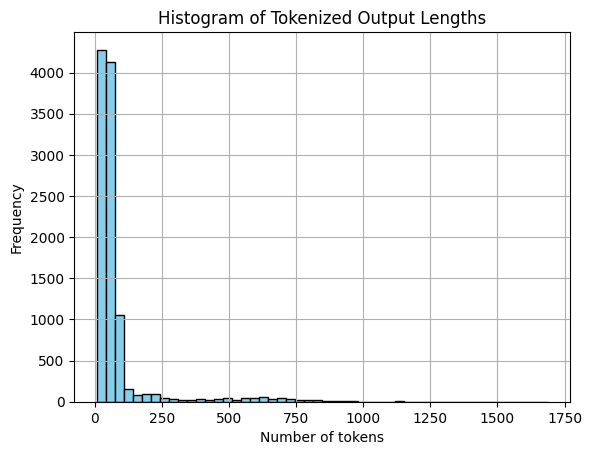

In [4]:
import matplotlib.pyplot as plt
lengths = [len(tokenizer(example['output'])['input_ids']) for example in dataset['train']]

# Plot the histogram
plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Tokenized Output Lengths")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [5]:
messages = [
    [
        {
            "role": "system",
            "content": [{"type": "text", "text": "You are a helpful assistant"},]
        },
        {
            "role": "user",
            "content": [{"type": "text", "text": "what is capital of france?"},]
        },
    ],
]
inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
).to(model.device).to(torch.float16)


with torch.inference_mode():
    outputs = model.generate(**inputs, max_new_tokens=64)

# outputs = tokenizer.batch_decode(outputs)

Attempting to cast a BatchEncoding to type torch.float16. This is not supported.


In [6]:
outputs = tokenizer.batch_decode(outputs)
print(outputs)

['<bos><start_of_turn>user\nYou are a helpful assistant\n\nwhat is capital of france?<end_of_turn>\n<start_of_turn>model\nThe capital of France is **Paris**. üòä \n\nDo you want to know anything else about Paris, or perhaps France in general?<end_of_turn>']


## Create the Dataset Object for Pytorch-Dataset

In [7]:
# Custom PyTorch Dataset
class LlamaDataset(Dataset):
    def __init__(self, dataset):
        self.data = dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        question=sample['instruction']
        answer = sample['output']
        prompt = f'''<bos><start_of_turn>user\n{question}<end_of_turn>\n<start_of_turn>model\n'''
        full_text = prompt+f'''{answer}<end_of_turn>'''

        tokenized = tokenizer(full_text, truncation=True, add_special_tokens=False, padding="max_length", max_length=200)

        input_ids = tokenized["input_ids"]
        attention_mask = tokenized["attention_mask"]

        # Tokenize just the prompt to get the split point
        prompt_ids = tokenizer(prompt, add_special_tokens=False)["input_ids"]
        answer_start = len(prompt_ids)

        # Mask everything before answer_start
        labels = [-100] * answer_start + input_ids[answer_start:]
        # Mask out padding as well
        labels = [
            label if token != tokenizer.pad_token_id else -100
            for label, token in zip(labels, input_ids)
        ]
    
        return {
        "input_ids": torch.tensor(input_ids),
        "attention_mask": torch.tensor(attention_mask),
        "labels": torch.tensor(labels)
    }
        

In [22]:
train_dataset = LlamaDataset(dataset['train'])
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [9]:
for param in model.named_parameters():
    print(param[0],' dtype:',param[1].dtype, ' requirs grad: ',param[1].requires_grad)

vision_tower.vision_model.embeddings.patch_embedding.weight  dtype: torch.bfloat16  requirs grad:  True
vision_tower.vision_model.embeddings.patch_embedding.bias  dtype: torch.bfloat16  requirs grad:  True
vision_tower.vision_model.embeddings.position_embedding.weight  dtype: torch.bfloat16  requirs grad:  True
vision_tower.vision_model.encoder.layers.0.layer_norm1.weight  dtype: torch.bfloat16  requirs grad:  True
vision_tower.vision_model.encoder.layers.0.layer_norm1.bias  dtype: torch.bfloat16  requirs grad:  True
vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.weight  dtype: torch.uint8  requirs grad:  False
vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.bias  dtype: torch.bfloat16  requirs grad:  False
vision_tower.vision_model.encoder.layers.0.self_attn.v_proj.weight  dtype: torch.uint8  requirs grad:  False
vision_tower.vision_model.encoder.layers.0.self_attn.v_proj.bias  dtype: torch.bfloat16  requirs grad:  False
vision_tower.vision_model.encoder.layer

# Purpose of `prepare_model_for_kbit_training`

When you load a model in 4-bit or 8-bit precision using bitsandbytes, some layers (like LayerNorm) still remain in full precision (float32), and certain operations (like weight updates) can be unstable or incompatible if done blindly on quantized weights.

- Casts `LayerNorm` layers to `float32`
- Sets `requires_grad=False` for all model parameters
- Wraps the output layer (like `lm_head`) in `float32`

In [10]:
# model = prepare_model_for_kbit_training(model)

In [11]:
target_modules = []
for name, module in model.named_modules():
    if "vision_tower.vision_model" not in name:  # Exclude vision tower
        if isinstance(module, torch.nn.Linear):
            # You might want to be more specific and only target attention and MLP layers
            if any(layer_name in name for layer_name in ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "down_proj", "up_proj"]):
                target_modules.append(name) # Get the leaf node name
target_modules


['language_model.model.layers.0.self_attn.q_proj',
 'language_model.model.layers.0.self_attn.k_proj',
 'language_model.model.layers.0.self_attn.v_proj',
 'language_model.model.layers.0.self_attn.o_proj',
 'language_model.model.layers.0.mlp.gate_proj',
 'language_model.model.layers.0.mlp.up_proj',
 'language_model.model.layers.0.mlp.down_proj',
 'language_model.model.layers.1.self_attn.q_proj',
 'language_model.model.layers.1.self_attn.k_proj',
 'language_model.model.layers.1.self_attn.v_proj',
 'language_model.model.layers.1.self_attn.o_proj',
 'language_model.model.layers.1.mlp.gate_proj',
 'language_model.model.layers.1.mlp.up_proj',
 'language_model.model.layers.1.mlp.down_proj',
 'language_model.model.layers.2.self_attn.q_proj',
 'language_model.model.layers.2.self_attn.k_proj',
 'language_model.model.layers.2.self_attn.v_proj',
 'language_model.model.layers.2.self_attn.o_proj',
 'language_model.model.layers.2.mlp.gate_proj',
 'language_model.model.layers.2.mlp.up_proj',
 'language

In [12]:
config = LoraConfig(
    r=64,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 131,153,920 || all params: 4,431,233,392 || trainable%: 2.9598


In [13]:
for param in model.named_parameters():
    print(param[0],' dtype:',param[1].dtype, ' requirs grad: ',param[1].requires_grad)

base_model.model.vision_tower.vision_model.embeddings.patch_embedding.weight  dtype: torch.bfloat16  requirs grad:  False
base_model.model.vision_tower.vision_model.embeddings.patch_embedding.bias  dtype: torch.bfloat16  requirs grad:  False
base_model.model.vision_tower.vision_model.embeddings.position_embedding.weight  dtype: torch.bfloat16  requirs grad:  False
base_model.model.vision_tower.vision_model.encoder.layers.0.layer_norm1.weight  dtype: torch.bfloat16  requirs grad:  False
base_model.model.vision_tower.vision_model.encoder.layers.0.layer_norm1.bias  dtype: torch.bfloat16  requirs grad:  False
base_model.model.vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.base_layer.weight  dtype: torch.uint8  requirs grad:  False
base_model.model.vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.base_layer.bias  dtype: torch.bfloat16  requirs grad:  False
base_model.model.vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.lora_A.default.weight  dtype: torch

In [14]:
# question = '''‡¨ì‡¨°‡¨º‡¨ø‡¨∂‡¨æ‡¨∞‡≠á ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨®‡¨ï‡≠Å ‡¨™‡≠ç‡¨∞‡≠ã‡¨§‡≠ç‡¨∏‡¨æ‡¨π‡¨® ‡¨¶‡≠á‡¨¨‡¨æ ‡¨™‡¨æ‡¨á‡¨Å ‡¨∏‡¨∞‡¨ï‡¨æ‡¨∞‡≠Ä ‡¨è‡¨¨‡¨Ç ‡¨ò‡¨∞‡≠ã‡¨á ‡¨ï‡≠ç‡¨∑‡≠á‡¨§‡≠ç‡¨∞ ‡¨ï‡¨ø‡¨™‡¨∞‡¨ø ‡¨Æ‡¨ø‡¨≥‡¨ø‡¨Æ‡¨ø‡¨∂‡¨ø ‡¨ï‡¨æ‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü ‡¨ï‡¨∞‡¨ø‡¨™‡¨æ‡¨∞‡¨ø‡¨¨‡≠á?'''
# answer = '''‡¨Ø‡≠á‡¨ï‡≠å‡¨£‡¨∏‡¨ø ‡¨∞‡¨æ‡¨ú‡≠ç‡≠ü‡¨∞‡≠á ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨®‡¨ï‡≠Å ‡¨™‡≠ç‡¨∞‡≠ã‡¨§‡≠ç‡¨∏‡¨æ‡¨π‡¨® ‡¨¶‡≠á‡¨¨‡¨æ ‡¨™‡¨æ‡¨á‡¨Å ‡¨∏‡¨∞‡¨ï‡¨æ‡¨∞‡≠Ä ‡¨è‡¨¨‡¨Ç ‡¨ò‡¨∞‡≠ã‡¨á ‡¨ï‡≠ç‡¨∑‡≠á‡¨§‡≠ç‡¨∞‡¨∞ ‡¨Æ‡¨ø‡¨≥‡¨ø‡¨§ ‡¨™‡≠ç‡¨∞‡≠ü‡¨æ‡¨∏‡¨∞ ‡¨Ü‡¨¨‡¨∂‡≠ç‡≠ü‡¨ï‡¨§‡¨æ ‡¨∞‡¨π‡¨ø‡¨õ‡¨ø‡•§ ‡¨ì‡¨°‡¨º‡¨ø‡¨∂‡¨æ‡¨∞ ‡¨∏‡¨∞‡¨ï‡¨æ‡¨∞‡≠Ä ‡¨è‡¨¨‡¨Ç ‡¨ò‡¨∞‡≠ã‡¨á ‡¨ï‡≠ç‡¨∑‡≠á‡¨§‡≠ç‡¨∞ ‡¨∞‡¨æ‡¨ú‡≠ç‡≠ü‡¨∞‡≠á ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨®‡¨ï‡≠Å ‡¨™‡≠ç‡¨∞‡≠ã‡¨§‡≠ç‡¨∏‡¨æ‡¨π‡¨® ‡¨¶‡≠á‡¨¨‡¨æ ‡¨≤‡¨æ‡¨ó‡¨ø ‡¨è‡¨ï ‡¨¨‡¨ø‡¨∏‡≠ç‡¨§‡≠É‡¨§ ‡¨∞‡¨£‡¨®‡≠Ä‡¨§‡¨ø ‡¨¨‡¨ø‡¨ï‡¨∂‡¨ø‡¨§ ‡¨è‡¨¨‡¨Ç ‡¨ï‡¨æ‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ï‡¨æ‡¨∞‡≠Ä ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ ‡¨≤‡¨æ‡¨ó‡¨ø ‡¨Æ‡¨ø‡¨≥‡¨ø‡¨§ ‡¨≠‡¨æ‡¨¨‡≠á ‡¨ï‡¨æ‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü ‡¨ï‡¨∞‡¨ø‡¨™‡¨æ‡¨∞‡¨ø‡¨¨‡≠á‡•§
# ‡¨∏‡¨∞‡¨ï‡¨æ‡¨∞ ‡¨ò‡¨∞‡≠ã‡¨á ‡¨ï‡≠ç‡¨∑‡≠á‡¨§‡≠ç‡¨∞ ‡¨∏‡¨π‡¨ø‡¨§ ‡¨Æ‡¨ø‡¨∂‡¨ø ‡¨ï‡¨æ‡¨Æ ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ‡¨∞ ‡¨ó‡≠ã‡¨ü‡¨ø‡¨è ‡¨â‡¨™‡¨æ‡≠ü ‡¨π‡≠á‡¨≤‡¨æ ‡¨ò‡¨∞‡≠ã‡¨á ‡¨®‡¨ø‡¨¨‡≠á‡¨∂ ‡¨™‡¨æ‡¨á‡¨Å ‡¨Ö‡¨®‡≠Å‡¨ï‡≠Ç‡¨≥ ‡¨¨‡¨æ‡¨§‡¨æ‡¨¨‡¨∞‡¨£ ‡¨∏‡≠É‡¨∑‡≠ç‡¨ü‡¨ø ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ, ‡¨è‡¨•‡¨ø‡¨∞‡≠á ‡¨ò‡¨∞‡≠ã‡¨á ‡¨ï‡≠ç‡¨∑‡≠á‡¨§‡≠ç‡¨∞‡¨∞ ‡¨≠‡¨æ‡¨ó‡¨ø‡¨¶‡¨æ‡¨∞‡≠Ä‡¨ï‡≠Å ‡¨™‡≠ç‡¨∞‡≠ã‡¨§‡≠ç‡¨∏‡¨æ‡¨π‡¨ø‡¨§ ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ ‡¨™‡¨æ‡¨á‡¨Å ‡¨ü‡¨ø‡¨ï‡¨∏ ‡¨è‡¨¨‡¨Ç ‡¨®‡¨ø‡≠ü‡¨æ‡¨Æ‡¨ï ‡¨™‡≠ç‡¨∞‡¨§‡¨ø‡¨¨‡¨®‡≠ç‡¨ß‡¨ï‡¨ï‡≠Å ‡¨π‡≠ç‡¨∞‡¨æ‡¨∏ ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ, ‡¨è‡¨π‡¨æ ‡¨¨‡≠ç‡≠ü‡¨§‡≠Ä‡¨§ ‡¨∏‡¨∞‡¨ï‡¨æ‡¨∞ ‡¨ü‡¨ø‡¨ï‡¨∏ ‡¨∞‡¨ø‡¨π‡¨æ‡¨§‡¨ø, ‡¨∏‡¨¨‡¨∏‡¨ø‡¨°‡¨ø ‡¨è‡¨¨‡¨Ç ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨® ‡¨¨‡¨ø‡¨ï‡¨æ‡¨∂ ‡¨™‡≠ç‡¨∞‡¨ï‡¨≥‡≠ç‡¨™ ‡¨™‡¨æ‡¨á‡¨Å ‡¨ú‡¨Æ‡¨ø ‡¨Ü‡¨¶‡¨ø ‡¨™‡≠ç‡¨∞‡≠ã‡¨§‡≠ç‡¨∏‡¨æ‡¨π‡¨® ‡¨Æ‡¨ß‡≠ç‡≠ü ‡¨™‡≠ç‡¨∞‡¨¶‡¨æ‡¨® ‡¨ï‡¨∞‡¨ø‡¨™‡¨æ‡¨∞‡¨ø‡¨¨‡≠á‡•§
# ‡¨ò‡¨∞‡≠ã‡¨á ‡¨ï‡≠ç‡¨∑‡≠á‡¨§‡≠ç‡¨∞ ‡¨∏‡¨π ‡¨Æ‡¨ø‡¨∂‡¨ø ‡¨∏‡¨∞‡¨ï‡¨æ‡¨∞ ‡¨ò‡¨∞‡≠ã‡¨á ‡¨ï‡≠ç‡¨∑‡≠á‡¨§‡≠ç‡¨∞ ‡¨∏‡¨π ‡¨Æ‡¨ø‡¨∂‡¨ø ‡¨®‡≠Ç‡¨§‡¨® ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨® ‡¨â‡¨§‡≠ç‡¨™‡¨æ‡¨¶ ‡¨™‡≠ç‡¨∞‡¨∏‡≠ç‡¨§‡≠Å‡¨§ ‡¨ï‡¨∞‡¨ø‡¨™‡¨æ‡¨∞‡¨ø‡¨¨‡≠á ‡¨Ø‡¨æ‡¨π‡¨æ ‡¨â‡¨≠‡≠ü ‡¨ò‡¨∞‡≠ã‡¨á ‡¨è‡¨¨‡¨Ç ‡¨Ö‡¨®‡≠ç‡¨§‡¨∞‡≠ç‡¨ú‡¨æ‡¨§‡≠Ä‡≠ü ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨ï‡¨ô‡≠ç‡¨ï ‡¨Ü‡¨¨‡¨∂‡≠ç‡≠ü‡¨ï‡¨§‡¨æ ‡¨™‡≠Ç‡¨∞‡¨£ ‡¨ï‡¨∞‡¨ø‡¨™‡¨æ‡¨∞‡¨ø‡¨¨‡•§
# ‡¨∏‡¨∞‡¨ï‡¨æ‡¨∞ ‡¨Æ‡¨ß‡≠ç‡≠ü ‡¨ì‡¨°‡¨º‡¨ø‡¨∂‡¨æ‡¨∞‡≠á ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨®‡¨ï‡≠Å ‡¨™‡≠ç‡¨∞‡≠ã‡¨§‡≠ç‡¨∏‡¨æ‡¨π‡¨® ‡¨¶‡≠á‡¨¨‡¨æ ‡¨è‡¨¨‡¨Ç ‡¨ò‡¨∞‡≠ã‡¨á ‡¨ï‡≠ç‡¨∑‡≠á‡¨§‡≠ç‡¨∞‡¨∞ ‡¨≠‡¨æ‡¨ó‡¨ø‡¨¶‡¨æ‡¨∞‡≠Ä‡¨ï‡≠Å ‡¨™‡≠ç‡¨∞‡≠ã‡¨§‡≠ç‡¨∏‡¨æ‡¨π‡¨ø‡¨§ ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ ‡¨™‡¨æ‡¨á‡¨Å ‡¨™‡≠ç‡¨∞‡¨Ø‡≠Å‡¨ï‡≠ç‡¨§‡¨ø‡¨∞ ‡¨â‡¨™‡¨Ø‡≠ã‡¨ó ‡¨ï‡¨∞‡¨ø‡¨™‡¨æ‡¨∞‡¨ø‡¨¨‡≠á‡•§ ‡¨â‡¨¶‡¨æ‡¨π‡¨∞‡¨£ ‡¨∏‡≠ç‡≠±‡¨∞‡≠Ç‡¨™, ‡¨∏‡¨∞‡¨ï‡¨æ‡¨∞ ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨® ‡¨∏‡≠ç‡¨•‡¨≥‡¨ï‡≠Å ‡¨™‡≠ç‡¨∞‡≠ã‡¨§‡≠ç‡¨∏‡¨æ‡¨π‡¨ø‡¨§ ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ ‡¨è‡¨¨‡¨Ç ‡¨∏‡¨Æ‡≠ç‡¨≠‡¨æ‡¨¨‡≠ç‡≠ü ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨ï‡¨Æ‡¨æ‡¨®‡¨ô‡≠ç‡¨ï ‡¨∏‡¨π‡¨ø‡¨§ ‡¨Ø‡≠ã‡¨°‡¨º‡¨ø‡¨¨‡¨æ ‡¨≤‡¨æ‡¨ó‡¨ø ‡¨∏‡≠ã‡¨∏‡¨ø‡¨Ü‡¨≤ ‡¨Æ‡¨ø‡¨°‡¨ø‡¨Ü ‡¨™‡≠ç‡¨≤‡¨æ‡¨ü‡¨´‡¨∞‡≠ç‡¨Æ‡¨∞ ‡¨â‡¨™‡¨Ø‡≠ã‡¨ó ‡¨ï‡¨∞‡¨ø‡¨™‡¨æ‡¨∞‡¨ø‡¨¨‡≠á‡•§ ‡¨ì‡¨°‡¨º‡¨ø‡¨∂‡¨æ‡¨∞‡≠á ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨® ‡¨Ü‡¨ï‡¨∞‡≠ç‡¨∑‡¨£ ‡¨è‡¨¨‡¨Ç ‡¨Ö‡¨®‡≠Å‡¨≠‡¨¨ ‡¨™‡≠ç‡¨∞‡¨¶‡¨∞‡≠ç‡¨∂‡¨ø‡¨§ ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ ‡¨≤‡¨æ‡¨ó‡¨ø ‡¨è‡¨ï ‡¨Ö‡¨®‡¨≤‡¨æ‡¨á‡¨® ‡¨™‡≠ç‡¨≤‡¨æ‡¨ü‡¨´‡¨∞‡≠ç‡¨Æ ‡¨™‡≠ç‡¨∞‡¨§‡¨ø‡¨∑‡≠ç‡¨†‡¨æ ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ ‡¨¶‡≠ç‡≠±‡¨æ‡¨∞‡¨æ ‡¨Ö‡¨ß‡¨ø‡¨ï ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨ï‡¨ô‡≠ç‡¨ï‡≠Å ‡¨Ü‡¨ï‡¨∞‡≠ç‡¨∑‡¨ø‡¨§ ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ‡¨∞‡≠á ‡¨∏‡¨π‡¨æ‡≠ü‡¨§‡¨æ ‡¨Æ‡¨ø‡¨≥‡¨ø‡¨™‡¨æ‡¨∞‡¨ø‡¨¨‡•§
# ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨®‡¨ï‡≠Å ‡¨™‡≠ç‡¨∞‡≠ã‡¨§‡≠ç‡¨∏‡¨æ‡¨π‡¨® ‡¨¶‡≠á‡¨¨‡¨æ ‡¨≤‡¨æ‡¨ó‡¨ø ‡¨∏‡¨∞‡¨ï‡¨æ‡¨∞‡≠Ä ‡¨è‡¨¨‡¨Ç ‡¨ò‡¨∞‡≠ã‡¨á ‡¨ï‡≠ç‡¨∑‡≠á‡¨§‡≠ç‡¨∞‡¨ï‡≠Å ‡¨Æ‡¨ø‡¨≥‡¨ø‡¨§ ‡¨≠‡¨æ‡¨¨‡≠á ‡¨ï‡¨æ‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ‡¨ï‡≠Å ‡¨™‡¨°‡¨ø‡¨¨ ‡¨Ø‡≠á‡¨™‡¨∞‡¨ø‡¨ï‡¨ø ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨® ‡¨ó‡¨§‡¨ø‡¨¨‡¨ø‡¨ß‡¨ø ‡¨¶‡≠ç‡≠±‡¨æ‡¨∞‡¨æ ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨æ‡¨¨‡¨∞‡¨£‡¨∞ ‡¨ï‡≠ç‡¨∑‡≠ü ‡¨ï‡¨ø‡¨Æ‡≠ç‡¨¨‡¨æ ‡¨∏‡≠ç‡¨•‡¨æ‡¨®‡≠Ä‡≠ü ‡¨∏‡¨Æ‡≠ç‡¨™‡≠ç‡¨∞‡¨¶‡¨æ‡≠ü‡¨∞ ‡¨ï‡≠ç‡¨∑‡¨§‡¨ø ‡¨® ‡¨π‡≠á‡¨â‡•§
# ‡¨∂‡≠á‡¨∑‡¨∞‡≠á, ‡¨∏‡¨∞‡¨ï‡¨æ‡¨∞‡≠Ä ‡¨è‡¨¨‡¨Ç ‡¨ò‡¨∞‡≠ã‡¨á ‡¨ï‡≠ç‡¨∑‡≠á‡¨§‡≠ç‡¨∞‡¨ï‡≠Å ‡¨ì‡¨°‡¨º‡¨ø‡¨∂‡¨æ‡¨∞‡≠á ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨®‡¨ï‡≠Å ‡¨™‡≠ç‡¨∞‡≠ã‡¨§‡≠ç‡¨∏‡¨æ‡¨π‡¨® ‡¨¶‡≠á‡¨¨‡¨æ ‡¨≤‡¨æ‡¨ó‡¨ø ‡¨è‡¨ï ‡¨Ö‡¨®‡≠Å‡¨ï‡≠Ç‡¨≥ ‡¨™‡¨∞‡¨ø‡¨¨‡≠á‡¨∂ ‡¨∏‡≠É‡¨∑‡≠ç‡¨ü‡¨ø ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ ‡¨Ü‡¨¨‡¨∂‡≠ç‡≠ü‡¨ï ‡¨è‡¨¨‡¨Ç ‡¨è‡¨π‡¨æ ‡¨∏‡≠Å‡¨®‡¨ø‡¨∂‡≠ç‡¨ö‡¨ø‡¨§ ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ ‡¨â‡¨ö‡¨ø‡¨§ ‡¨Ø‡≠á ‡¨¨‡¨ø‡¨ï‡¨æ‡¨∂ ‡¨∏‡≠ç‡¨•‡¨æ‡≠ü‡≠Ä ‡¨π‡≠á‡¨¨‡•§ ‚Äù ‡¨Æ‡¨ø‡¨≥‡¨ø‡¨§ ‡¨≠‡¨æ‡¨¨‡≠á ‡¨ï‡¨æ‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü ‡¨ï‡¨∞‡¨ø ‡¨∏‡≠á‡¨Æ‡¨æ‡¨®‡≠á ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨® ‡¨∞‡¨£‡¨®‡≠Ä‡¨§‡¨ø‡¨ï‡≠Å ‡¨¨‡¨ø‡¨ï‡¨∂‡¨ø‡¨§ ‡¨è‡¨¨‡¨Ç ‡¨ï‡¨æ‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ï‡¨æ‡¨∞‡≠Ä ‡¨ï‡¨∞‡¨ø‡¨™‡¨æ‡¨∞‡¨ø‡¨¨‡≠á ‡¨Ø‡¨æ‡¨π‡¨æ ‡¨ï‡≠á‡¨¨‡¨≥ ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨® ‡¨â‡¨¶‡≠ç‡≠ü‡≠ã‡¨ó ‡¨®‡≠Å‡¨π‡≠á‡¨Å ‡¨¨‡¨∞‡¨Ç ‡¨∏‡≠ç‡¨•‡¨æ‡¨®‡≠Ä‡≠ü ‡¨ó‡≠ã‡¨∑‡≠ç‡¨†‡≠Ä ‡¨è‡¨¨‡¨Ç ‡¨™‡¨∞‡¨ø‡¨¨‡≠á‡¨∂‡¨ï‡≠Å ‡¨Æ‡¨ß‡≠ç‡≠ü ‡¨≤‡¨æ‡¨≠‡¨æ‡¨®‡≠ç‡≠±‡¨ø‡¨§ ‡¨ï‡¨∞‡¨ø‡¨¨‡•§'''

# tokenized_text = tokenizer(answer).input_ids
# print(len(tokenized_text))
# for idx in range(len(tokenized_text)):
#     clear_output(wait=True)
#     print(tokenizer.decode(tokenized_text[0:idx]))
#     time.sleep(0.1)

# Finetune the LLAMA model on a single text

In [15]:
for batch in train_dataloader:
    break

tokenizer.batch_decode(batch['input_ids'],skip_special_tokens=True)

["user\n‡¨™‡≠ç‡¨∞‡¨æ‡¨∞‡¨Æ‡≠ç‡¨≠‡¨ø‡¨ï ‡¨è‡¨è‡¨Ü‡¨á ‡¨á‡¨Æ‡≠ç‡≠ü‡≠Å‡¨®‡≠ã‡¨≤‡≠ã‡¨ú‡¨ø ‡¨™‡¨æ‡¨†‡≠ç‡≠ü‡¨ï‡≠ç‡¨∞‡¨Æ ‡¨ï '‡¨£ ‡¨ï‡¨∞‡≠Å‡¨õ‡¨ø?\nmodel\n‡¨õ‡¨æ‡¨§‡≠ç‡¨∞‡¨õ‡¨æ‡¨§‡≠ç‡¨∞‡≠Ä‡¨ô‡≠ç‡¨ï‡≠Å ‡¨∞‡≠ã‡¨ó ‡¨™‡≠ç‡¨∞‡¨§‡¨ø‡¨∞‡≠ã‡¨ß‡¨ï ‡¨∂‡¨ï‡≠ç‡¨§‡¨ø ‡¨¨‡¨ø‡¨∑‡≠ü‡¨∞‡≠á ‡¨Ö‡¨¨‡¨ó‡¨§ ‡¨ï‡¨∞‡¨æ‡¨á‡¨•‡¨æ‡¨è",
 "user\n‡¨ï‡≠ã‡¨∞‡¨∏‡¨æ‡¨ï‡≠ã‡¨´‡≠ç ‡¨∏‡¨ø‡¨£‡≠ç‡¨°‡≠ç‡¨∞‡≠ã‡¨Æ ‡¨ï '‡¨£?\nmodel\n‡¨è‡¨ï ‡¨ú‡≠à‡¨¨‡¨ø‡¨ï ‡¨Æ‡¨∏‡≠ç‡¨§‡¨ø‡¨∑‡≠ç‡¨ï ‡¨∞‡≠ã‡¨ó ‡¨Ø‡¨æ‡¨π‡¨æ ‡¨™‡≠ç‡¨∞‡¨ø‡¨´‡≠ç‡¨∞‡¨£‡≠ç‡¨ü‡¨≤ ‡¨ï‡¨∞‡≠ç‡¨ü‡≠á‡¨ï‡≠ç‡¨∏ ‡¨Æ‡¨ß‡≠ç‡≠ü‡¨∞‡≠á ‡¨∏‡≠ç‡¨®‡¨æ‡≠ü‡≠Å‡¨ï‡≠ã‡¨∑‡¨∞ ‡¨¨‡≠ç‡≠ü‡¨æ‡¨™‡¨ï ‡¨ï‡≠ç‡¨∑‡¨§‡¨ø ‡¨ï‡¨ø‡¨Æ‡≠ç‡¨¨‡¨æ ‡¨∏‡¨ô‡≠ç‡¨ï‡≠ã‡¨ö‡¨® ‡¨¶‡≠ç‡≠±‡¨æ‡¨∞‡¨æ ‡¨∏‡≠ç‡¨Æ‡≠É‡¨§‡¨ø‡¨∂‡¨ï‡≠ç‡¨§‡¨ø‡¨ï‡≠Å ‡¨™‡≠ç‡¨∞‡¨§‡¨ø‡¨ï‡≠Ç‡¨≥ ‡¨≠‡¨æ‡¨¨‡≠á ‡¨™‡≠ç‡¨∞‡¨≠‡¨æ‡¨¨‡¨ø‡¨§ ‡¨ï‡¨∞‡¨ø‡¨•‡¨æ‡¨è‡•§"]

In [16]:
def generate_eval(model,idx=5,disable_lora=False):
    
    model.config.use_cache = True
    sample=dataset['train'][idx]
    question=sample['instruction']
    answer = sample['output']
    chat_template = f'''<bos><start_of_turn>user\n{question}<end_of_turn>\n<start_of_turn>model\n'''
    inputs = tokenizer(chat_template , return_tensors="pt").to(device).to(torch.float16)
    # print(prompt)

    model.eval()


    if disable_lora:
        with model.disable_adapter():
            output = model.generate(
                **inputs,
                do_sample=True,
                max_new_tokens=256,
                repetition_penalty=1.3,
                temperature=0.7,         # Optional: smooth randomness
                top_k=50,                # Optional: top-k sampling
                top_p=0.9                # Optional: nucleus sampling
            )
    else:
        output = model.generate(
        **inputs,
        do_sample=True,
        max_new_tokens=256,
        repetition_penalty=1.3,
        temperature=0.7,         # Optional: smooth randomness
        top_k=50,                # Optional: top-k sampling
        top_p=0.9                # Optional: nucleus sampling
        )

    processed_text = tokenizer.decode(output[0], skip_special_tokens=False)
    
    model.train()

    return processed_text

In [17]:
dataset['train'][40]

{'instruction': '‡¨≠‡≠Å‡¨¨‡¨®‡≠á‡¨∂‡≠ç‡≠±‡¨∞‡¨∞ ‡¨∞‡¨æ‡¨ú‡¨æ‡¨∞‡¨æ‡¨£‡≠Ä ‡¨Æ‡¨®‡≠ç‡¨¶‡¨ø‡¨∞‡¨∞ ‡¨á‡¨§‡¨ø‡¨π‡¨æ‡¨∏ ‡¨ï‚Äô‡¨£?',
 'input': '',
 'output': '‡¨è‡¨ï‡¨æ‡¨¶‡¨∂ ‡¨∂‡¨§‡¨æ‡¨¨‡≠ç‡¨¶‡≠Ä‡¨∞‡≠á ‡¨®‡¨ø‡¨∞‡≠ç‡¨Æ‡¨æ‡¨£ ‡¨ï‡¨∞‡¨æ‡¨Ø‡¨æ‡¨á‡¨•‡¨ø‡¨¨‡¨æ ‡¨∞‡¨æ‡¨ú‡¨æ‡¨∞‡¨æ‡¨£‡≠Ä ‡¨Æ‡¨®‡≠ç‡¨¶‡¨ø‡¨∞ ‡¨≠‡≠Å‡¨¨‡¨®‡≠á‡¨∂‡≠ç‡≠±‡¨∞ ‡¨∏‡¨π‡¨∞‡¨∞ ‡¨è‡¨ï ‡¨≤‡≠ã‡¨ï‡¨™‡≠ç‡¨∞‡¨ø‡≠ü ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨®‡¨∏‡≠ç‡¨•‡¨≥‡≠Ä‡•§\n‡¨è‡¨ï‡¨æ‡¨¶‡¨∂ ‡¨∂‡¨§‡¨æ‡¨¨‡≠ç‡¨¶‡≠Ä‡¨∞‡≠á ‡¨è‡¨π‡¨ø ‡¨Ö‡¨Ç‡¨ö‡¨≥‡¨∞‡≠á ‡¨∞‡¨æ‡¨ú‡¨æ‡¨∞‡¨æ‡¨£‡≠Ä ‡¨∞‡¨æ‡¨ú‡¨¨‡¨Ç‡¨∂ ‡¨∂‡¨æ‡¨∏‡¨® ‡¨ï‡¨∞‡¨ø‡¨•‡¨ø‡¨≤‡≠á‡•§ ‡¨¨‡¨ø‡¨∂‡≠ç‡≠±‡¨æ‡¨∏ ‡¨ï‡¨∞‡¨æ‡¨Ø‡¨æ‡¨è ‡¨Ø‡≠á ‡¨è‡¨π‡¨ø ‡¨Æ‡¨®‡≠ç‡¨¶‡¨ø‡¨∞ ‡¨™‡≠ç‡¨∞‡¨•‡¨Æ‡≠á ‡¨≠‡¨ó‡¨¨‡¨æ‡¨® ‡¨∂‡¨ø‡¨¨‡¨ô‡≠ç‡¨ï‡≠Å ‡¨∏‡¨Æ‡¨∞‡≠ç‡¨™‡¨ø‡¨§ ‡¨•‡¨ø‡¨≤‡¨æ, ‡¨ï‡¨ø‡¨®‡≠ç‡¨§‡≠Å ‡¨™‡¨∞‡≠á ‡¨è‡¨π‡¨æ ‡¨≠‡¨ó‡¨¨‡¨æ‡¨® ‡¨¨‡¨ø‡¨∑‡≠ç‡¨£‡≠Å‡¨ô‡≠ç‡¨ï ‡¨Æ‡¨®‡≠ç‡¨¶‡¨ø‡¨∞ ‡¨™‡¨æ‡¨≤‡¨ü‡¨ø‡¨•‡¨ø‡¨≤‡¨æ‡•§\n‡¨∞‡¨æ‡¨ú‡¨æ‡¨∞‡¨æ‡¨£‡≠Ä ‡¨Æ‡¨®‡≠ç‡¨¶‡¨ø‡¨∞‡¨∞ ‡¨∏‡≠ç‡¨•‡¨æ‡¨™‡¨§‡≠ç‡≠ü ‡¨Ö‡¨¶‡≠ç‡≠±‡¨ø‡¨§‡≠Ä‡≠ü, ‡¨ï‡¨æ‡¨∞‡¨£ ‡¨è‡¨†‡¨æ‡¨∞‡≠á ‡¨ï

In [18]:
pred = generate_eval(model=model,idx=40,disable_lora=False)
print(pred)

Attempting to cast a BatchEncoding to type torch.float16. This is not supported.


<bos><bos><start_of_turn>user
‡¨≠‡≠Å‡¨¨‡¨®‡≠á‡¨∂‡≠ç‡≠±‡¨∞‡¨∞ ‡¨∞‡¨æ‡¨ú‡¨æ‡¨∞‡¨æ‡¨£‡≠Ä ‡¨Æ‡¨®‡≠ç‡¨¶‡¨ø‡¨∞‡¨∞ ‡¨á‡¨§‡¨ø‡¨π‡¨æ‡¨∏ ‡¨ï‚Äô‡¨£?<end_of_turn>
<start_of_turn>model
‡¨Æ‡≠ã‡¨ü ‡¨¶‡¨æ‡¨®‡¨ó ‡¨¨‡¨ø‡¨≤‡≠ç‡≠ü ‡¨∏‡¨Ç‡¨π‡¨ø‡¨§ ‡¨≠‡≠Å‡¨¨‡¨æ‡¨û‡≠ç‡¨ö‡¨≥ ‡¨ì‡¨°‡¨º‡¨â ‡¨™‡¨∞‡¨ø‡¨™‡≠Ç‡¨∞‡≠ç‡¨£‡≠ç‡¨£ ‡¨™‡≠ç‡¨∞‡¨ï‡≠É‡¨∑‡≠ç‡¨ü‡¨ø‡¨Ü‡¨ô‡≠ç‡¨ó ‡¨¨‡¨π‡≠Å‡¨¶‡¨æ‡¨®‡¨ô‡≠ç‡¨ï ‡¨ú‡¨®‡¨æ ‡¨Ö‡¨ß‡¨ø‡¨ï‡¨æ‡¨∞ ‡¨Ü‡≠ü‡¨§‡≠ç‡¨µ‡¨∞‡≠á ‡¨ó‡≠ç‡¨∞‡¨®‡≠ç‡¨• ‡¨∂‘±‡¨®‡≠ç‡¨§‡¨ø ‡¨®‡¨ø‡¨ï‡¨ü ‡¨è‡¨ï ‡¨Ø‡≠ã‡¨ú‡¨®‡¨æ‡¨∞ ‡¨∞‡¨ï‡≠ç‡¨∑‡¨æ ‡¨π‡≠ã‡¨á‡¨•‡¨ø‡¨≤‡¨æ ‡•§ ‡¨Ö‡¨®‡≠ç‡¨§‡¨É‡¨∏‡≠ç ‡¨ö‡¨æ‡¨∞‡≠ç‡¨ï‡¨æ‡¨∞‡≠ç‡¨Ø ‡¨ï‡¨≤‡≠á ‡¨∏‡¨Æ‡≠ç‡¨ò‡≠É‡¨§‡¨æ ‡¨ñ‡¨®‡¨ø, ‡¨Ö‡¨™‡≠ç‡¨∞‡¨æ‡¨π‡¨ø‡¨≥ ‡¨∂‡¨§‡≠ç‡¨∞‡≠Å, ‡¨∏‡≠å‡¨≥ ‡¨∏‡¨Æ‡≠ç‡¨™‡¨∞‡≠ç‡¨ï, ‡¨è‡¨¨‡¨Ç ‡¨ï‡≠ç‡¨∞‡¨Æ-‡¨ï‡≠ç‡¨∞‡¨Æ ‡¨∏‡≠å‡¨≥ ‡¨∏‡¨Æ‡≠ç‡¨™‡¨∞‡≠ç‡¨ï ‡¨∏‡¨Ç‡¨∂ contested‡•§

‡¨Ö‡¨∞‡≠ç‡¨•‡§æ‡§§‡•ç ‡¨ó‡≠ç‡¨∞‡¨®‡≠ç‡¨• ‡¨∂‘±‡¨®‡≠ç‡¨§‡¨ø ‡¨®‡¨ø‡¨ï‡¨ü ‡¨∏‡¨Ç‡¨™‡≠Ç‡¨∞‡≠ç‡¨£‡≠ç‡¨£ ‡¨¨‡¨ø ‡¨ï‡¨∞‡¨ø‡¨•‡¨ø‡¨≤‡¨æ‡•§ ‡¨Ø‡≠á‡¨§‡¨®‡≠á‡¨Ω‡¨ü‡¨ø ‡¨Æ‡¨æ‡¨ù‡¨æ‡¨ó‡≠ç‡¨∞‡≠Ä ‡¨ó‡≠ç‡¨∞‡¨®‡≠ç‡¨• ‡¨∂‘±‡

In [ ]:
model.config.use_cache = False
model.config.pretraining_tp = 1
gradient_accumulation_steps = 4
max_steps=500
max_loss = 1e9


# Define optimizer
optimizer = Adam8bit(model.parameters(), lr=1e-4)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=max_steps,
)
# Training loop
model.train()

global_step= 0

while global_step< max_steps:
    for step,batch in enumerate(train_dataloader):
        model.config.use_cache = False
        model.train()
        
        # Forward pass
        outputs = model(input_ids=batch['input_ids'].to('cuda'), attention_mask=batch['attention_mask'].to('cuda'), labels=batch['labels'].to('cuda'))
        loss = outputs.loss
        loss = loss / gradient_accumulation_steps  # Normalize loss
        loss.backward()
        
        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
        
        global_step += 1
        if global_step >= max_steps:
            break
        
        if global_step % 20 == 0:
            pred = generate_eval(model=model,idx=40,disable_lora=False)
            print('*'*20,step+1,'*'*20)
            print("Predictions:", pred)
            print('*'*20,'end','*'*20)
            
        if loss.item() < max_loss:
            model.save_pretrained('/home/nas/buffer/mohan.dash/llama_3_finetuned/adapter')
            max_loss = loss.item()
            
            
            
        
        print(f"Epoch {global_step + 1}/{max_steps}, Loss: {loss.item():.4f}")
         
flush()

Epoch 2/500, Loss: 0.4840
Epoch 3/500, Loss: 0.5525
Epoch 4/500, Loss: 0.3825
Epoch 5/500, Loss: 0.4653
Epoch 6/500, Loss: 0.5354
Epoch 7/500, Loss: 0.2869
Epoch 8/500, Loss: 0.5344
Epoch 9/500, Loss: 0.4573
Epoch 10/500, Loss: 0.4764
Epoch 11/500, Loss: 0.5638
Epoch 12/500, Loss: 0.4279
Epoch 13/500, Loss: 0.4473
Epoch 14/500, Loss: 0.4151
Epoch 15/500, Loss: 0.4112
Epoch 16/500, Loss: 0.4534
Epoch 17/500, Loss: 0.4320


KeyboardInterrupt: 

# Loading the LoRA and saving the Adapter

In [ ]:
# model_with_adapter.save_pretrained('/home/nas/buffer/mohan.dash/llama_3_finetuned/adapter')

In [7]:
# Load the adapter into the base model
model = PeftModel.from_pretrained(model, '/home/nas/buffer/mohan.dash/llama_3_finetuned/adapter')
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 3072)
        (layers): ModuleList(
          (0-27): 28 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj):

In [10]:
pred = generate_eval(model,idx=40,disable_lora=False)
print(pred)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|><|begin_of_text|> <|start_header_id|>user<|end_header_id|>

‡¨≠‡≠Å‡¨¨‡¨®‡≠á‡¨∂‡≠ç‡≠±‡¨∞‡¨∞ ‡¨∞‡¨æ‡¨ú‡¨æ‡¨∞‡¨æ‡¨£‡≠Ä ‡¨Æ‡¨®‡≠ç‡¨¶‡¨ø‡¨∞‡¨∞ ‡¨á‡¨§‡¨ø‡¨π‡¨æ‡¨∏ ‡¨ï‚Äô‡¨£?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

‡¨™‡≠Ç‡¨∞‡≠ç‡¨¨-‡¨ó‡≠ã‡¨ü‡¨ø‡¨è ‡¨ñ‡≠à‡¨≥‡¨ß‡¨ô‡≠ç‡¨ö, ‡¨Ø‡≠á‡¨â‡¨Å‡¨†‡¨ø ‡¨Ö‡¨Ç‡¨ò‡¨æ‡¨°‡¨º‡¨ø ‡¨∏‡≠É‡¨∑‡≠ç‡¨ü‡¨ø ‡¨•‡¨ø‡¨≤‡¨æ‡•§ ‡¨Ü‡¨û‡≠ç‡¨ö‡¨≥‡¨ø‡¨ï ‡¨∏‡≠å‡¨®‡≠ç‡¨¶‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü ‡¨∏‡¨´‡¨∞ ‡¨ï‡¨∞‡¨ø‡¨õ‡¨ø, ‡¨ì ‡¨∏‡≠ç‡¨•‡¨æ‡¨®‡≠Ä‡≠ü ‡¨î‡¨™‡¨®‡¨ø‡¨¨‡≠á‡¨∂‡¨ï‡¨Æ‡¨æ‡¨®‡≠á ‡¨™‡≠ç‡¨∞‡¨µ‡≠á‡¨∂ ‡¨ï‡¨∞‡≠Å‡¨õ‡¨®‡≠ç‡¨§‡¨ø‡•§
" " - ‡¨¢. ‡¨™‡≠ç‡¨∞‡≠ã‡¨´‡≠á‡¨∏‡¨∞ ‡¨ê. ‡¨∞‡≠á‡¨®‡¨ø (1928) | ‡¨è‡¨π‡¨æ ‡¨§‡≠ç‡¨∞‡≠ü‡≠ã‡¨¶‡¨∂ ‡¨∂‡¨§‡¨æ‡¨¨‡≠ç‡¨¶‡≠Ä‡¨∞‡≠á ‡¨∏‡¨Æ‡≠ç‡¨™‡¨∞‡≠ç‡¨ï‡¨ø‡¨§ ‡¨è‡¨ï ‡¨ú‡¨æ‡¨∞‡¨ø‡¨¨‡¨æ‡¨∞ ‡¨™‡¨æ‡¨≥‡¨® ‡¨ï‡¨∞‡≠Å‡¨õ‡¨ø ‡•§ ‡¨∞‡¨æ‡¨ú‡¨æ‡¨∞‡¨æ‡¨£‡≠Ä ‡¨¶‡≠Å


In [ ]:
# Path to your saved checkpoint
save_path = "/home/nas/buffer/mohan.dash/llama_3_finetuned/model_checkpoint.pt"

# Load checkpoint
checkpoint = torch.load(save_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')

# Restore model, optimizer, scheduler, and step
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
global_step = checkpoint['global_step']

# print(f"Checkpoint loaded from {save_path} at step {global_step}")

In [ ]:
checkpoint

In [ ]:
global_step = checkpoint['global_step']

In [ ]:
global_step

: 

In [ ]:
save_path = "/home/nas/buffer/mohan.dash/llama_3_finetuned/model_checkpoint.pt"

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'global_step': global_step
}, save_path)

print(f"Checkpoint saved to {save_path}")